# Jupiter Notebook to build a quick and imperfect prediction solution

This notebook is an attempt to train a model to predict the salary in Data Science based on the kaggle dataset from https://www.kaggle.com/datasets/lainguyn123/data-science-salary-landscape.

In [11]:
# Package for linear regressions


import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score,root_mean_squared_log_error
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')

## Loading and Cleaning datasets

In this section, we will load the dataset and extract the features and performs the cleaning.

In [12]:
pd.options.display.float_format = '{:.2f}'.format

salaries_dataset_url = './ds_salaries.csv'
full_dataset = pd.read_csv(salaries_dataset_url)
full_dataset.describe(include='all').T



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,607.00,NaN,NaN,NaN,303.00,175.37,0.00,151.50,303.00,454.50,606.00
work_year,607.00,NaN,NaN,NaN,2021.41,0.69,2020.00,2021.00,2022.00,2022.00,2022.00
experience_level,607,4,SE,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_type,607,4,FT,588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_title,607,50,Data Scientist,143,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary,607.00,NaN,NaN,NaN,324000.06,1544357.49,4000.00,70000.00,115000.00,165000.00,30400000.00
salary_currency,607,17,USD,398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary_in_usd,607.00,NaN,NaN,NaN,112297.87,70957.26,2859.00,62726.00,101570.00,150000.00,600000.00
employee_residence,607,57,US,332,NaN,NaN,NaN,NaN,NaN,NaN,NaN
remote_ratio,607.00,NaN,NaN,NaN,70.92,40.71,0.00,50.00,100.00,100.00,100.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Columns: 175 entries, remote_ratio to remote_ratio_str_50
dtypes: int64(175)
memory usage: 830.0 KB
<class 'pandas.core.series.Series'>
RangeIndex: 607 entries, 0 to 606
Series name: salary_in_usd
Non-Null Count  Dtype  
--------------  -----  
607 non-null    float64
dtypes: float64(1)
memory usage: 4.9 KB
Features num= 175 Index(['remote_ratio', 'work_year_2020', 'work_year_2021', 'work_year_2022',
       'experience_level_EN', 'experience_level_EX', 'experience_level_MI',
       'experience_level_SE', 'employment_type_CT', 'employment_type_FL',
       ...
       'company_location_TR', 'company_location_UA', 'company_location_US',
       'company_location_VN', 'company_size_L', 'company_size_M',
       'company_size_S', 'remote_ratio_str_0', 'remote_ratio_str_100',
       'remote_ratio_str_50'],
      dtype='object', length=175)


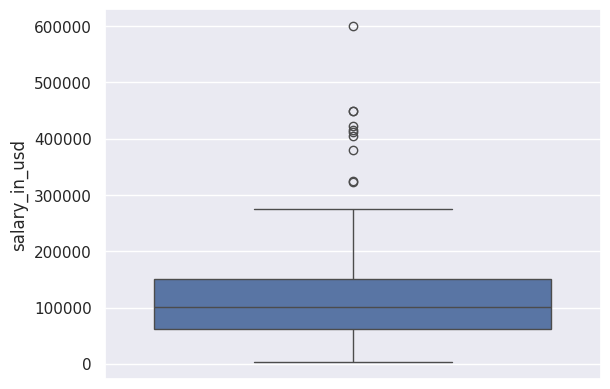

In [13]:

target_column = 'salary_in_usd'

#def my_preparation(X, Y):
# Reorder the salary column and remove the salary and currency columns and ID
ignored_cols =  ['Unnamed: 0', 'salary', 'salary_currency']
X = full_dataset.drop(ignored_cols, axis=1)
# We convert the work year as a categorical feature
X['work_year'] = X['work_year'].map(str)
X['remote_ratio_str'] = X['remote_ratio'].map(str)

data_with_dummies = pd.get_dummies(X, drop_first=False)
data_preprocessed = data_with_dummies.replace({True:1, False:0})

sns.boxplot(data_preprocessed[target_column])



X = data_preprocessed
X = X.drop(['salary_in_usd'], axis=1)


# We apply log on the salary feature
Y =  np.log(full_dataset[target_column])
X.info()
Y.info()
inputs = X
targets = Y
feature_cols = X.columns

print("Features num=", len(feature_cols), feature_cols)
# Export CSV
X.to_csv('train.csv', index=False)  

X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.1, random_state=42)


### Split the dataset in train and test



In [14]:
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("Y_train", y_train.shape)
print("Y_test", y_test.shape)

X_train (546, 175)
X_test (61, 175)
Y_train (546,)
Y_test (61,)


## Model training

We will use a hierarchical model to train.

In [15]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgbm
from sklearn.neural_network import MLPRegressor
def fit_model(inputs, targets):
  
    params_lr = {}#{'alpha': 2.1596631438375864, 'l1_ratio': 0.7621516892127179}
    params_dt = {'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 8}
    params_rf = {'n_estimators': 472, 'max_samples': 0.09686470240301956, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_leaf_nodes': 46}
    params_gb = {'n_estimators': 220, 'learning_rate': 0.03, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': 20}
    
    rg_net = ElasticNet(**params_lr) 
    rg_dt = DecisionTreeRegressor(**params_dt)
    rg_rf = RandomForestRegressor(**params_rf)
    rg_gb = GradientBoostingRegressor(**params_gb)
    rg_knn = KNeighborsRegressor(n_neighbors=3)
    rg_lr = LinearRegression();
    rg_ri = Ridge(alpha=0.001)
    
    estimators = [
        #('ElasticNet', rg_net),
        ('DecisionTree', rg_dt), 
        #('GradientBoosting', rg_gb),
        #('RandomForest', rg_rf),
        #("KNN", rg_knn),
        ("LR", rg_lr),   
        #('Ridge', rg_ri),
        ("mlp", MLPRegressor(hidden_layer_sizes = (7), solver = "lbfgs", max_iter = 1000, random_state = 13))
    ]
    stacking_regressor = StackingRegressor(estimators=estimators, cv=5, final_estimator=LinearRegression(), passthrough = False)
    stacking_regressor.fit(inputs, targets)
    return stacking_regressor


regr = fit_model( X_train, y_train )

## Predict the value for the test dataset
y_pred = regr.predict(X_test)
print(y_pred[0:5])
print(y_test[0:5])

## Compute Accuracy

print("mean_squared_log_error (MSLE): %.2f" % mean_squared_log_error(y_test, y_pred))  
print("root_mean_squared_log_error: %.2f" % root_mean_squared_log_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination, R2: %.2f" % r2_score(y_test, y_pred))


[11.85923775 11.85923775 11.86039649 11.96502637 10.6623056 ]
563   11.85
289   11.81
76    11.51
78    12.51
182   10.17
Name: salary_in_usd, dtype: float64
mean_squared_log_error (MSLE): 0.00
root_mean_squared_log_error: 0.05
Coefficient of determination, R2: 0.70


### Graph and precision evaluation

### Compute accuracy

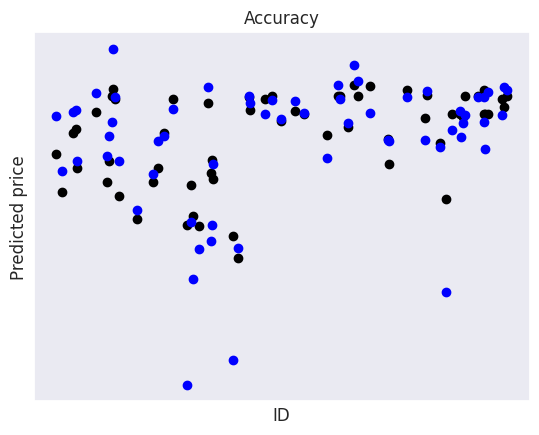

<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, 563 to 420
Columns: 178 entries, remote_ratio to id
dtypes: float64(2), int64(176)
memory usage: 85.3 KB
None


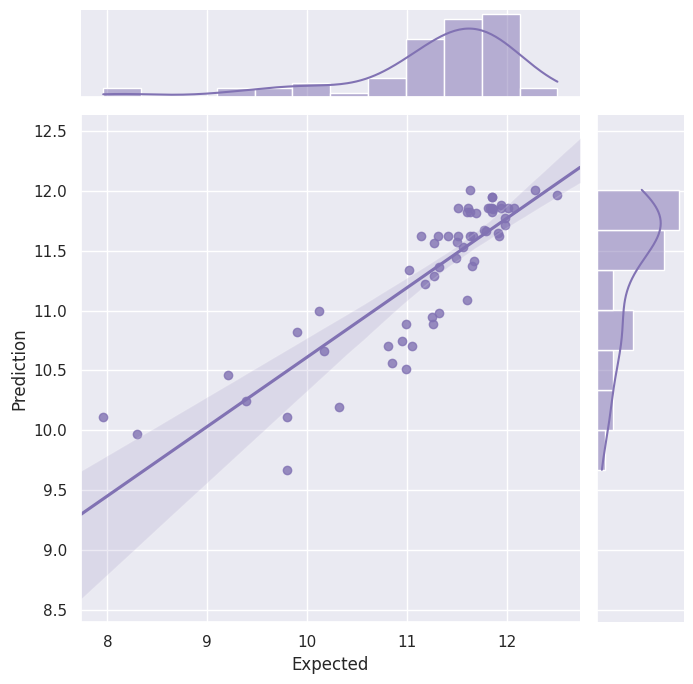

In [16]:

# Plot outputs
plt.scatter(X_test.index, y_pred, color="black")
plt.scatter(X_test.index, y_test, color="blue")
#plt.scatter(train["Id"], y_test, color="blue")
#plt.plot(test_features_X_df,  test_predicted_Y_df, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())
plt.tick_params(axis='both', labelsize=12, width=2, length=5)  # Style

plt.xlabel('ID')
plt.ylabel('Predicted price')
plt.title('Accuracy')
plt.show()


sns.set_theme(style="darkgrid")

data = X_test.copy()
data["Prediction" ] = y_pred
data["Expected" ] = y_test
data["id"] = data.index
print(data.info())
g = sns.jointplot(x="Expected", y="Prediction", data=data,
                  kind="reg", truncate=False,
                  color="m", height=7)


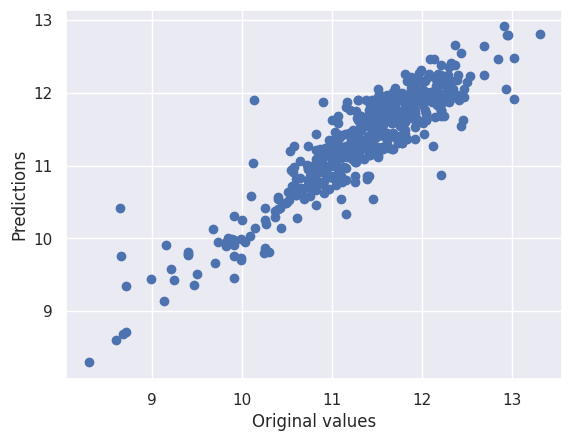

In [17]:
reg=LinearRegression()
reg.fit(X_train, y_train)
yhat = reg.predict(X_train)
plt.scatter(y_train, yhat)
plt.xlabel('Original values')
plt.ylabel('Predictions')
plt.show()


In [18]:
predictions = reg.predict(X_test)
predictions2 = regr.predict(X_test)


print("root_mean_squared_log_error: %.2f" % root_mean_squared_log_error(y_test, predictions))
print("root_mean_squared_log_error : complex: %.2f" % root_mean_squared_log_error(y_test, predictions2))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination, R2: %.2f" % r2_score(y_test, predictions))
print("Coefficient of determination complex, R2: %.2f" % r2_score(y_test, predictions2))



results = pd.DataFrame({'Prediction': np.exp(predictions), 'Actual': np.exp(y_test)})
results["Prediction my model"] = np.exp(predictions2)
results['Difference'] = np.exp(y_test) - np.exp(predictions)
results['Difference %'] = abs(results['Difference'])/results['Actual']
results['Difference2'] = np.exp(y_test) - np.exp(predictions2)
results['Difference2 %'] = abs(results['Difference2'])/results['Actual']

results.sort_values(by='Difference %')

root_mean_squared_log_error: 0.05
root_mean_squared_log_error : complex: 0.05
Coefficient of determination, R2: 0.67
Coefficient of determination complex, R2: 0.70


,Prediction,Actual,Prediction my model,Difference,Difference %,Difference2,Difference2 %
29,117107.52,117104.00,90850.37,-3.52,0.00,26253.63,0.22
443,77788.28,78526.00,79990.26,737.72,0.01,-1464.26,0.02
332,111734.43,112900.00,111689.22,1165.57,0.01,1210.78,0.01
540,111734.43,115934.00,111689.22,4199.57,0.04,4244.78,0.04
602,147545.69,154000.00,141384.41,6454.31,0.04,12615.59,0.08
...,...,...,...,...,...,...,...
238,7985.10,4000.00,21382.19,-3985.10,1.00,-17382.19,4.35
210,62035.27,24823.00,59612.00,-37212.27,1.50,-34789.00,1.40
521,41856.50,10000.00,35070.04,-31856.50,3.19,-25070.04,2.51
208,121799.85,20000.00,50257.61,-101799.85,5.09,-30257.61,1.51
